In [ ]:
"""
This notebook demonstrates how to compute spectrum of random matrices 
\Lambda_P=PU^{\dag}PUP and \Lambda_P=PU^{\dag}(1-P)UP.
Here P is a projector (with a specified rank) and U is random unitary.
U can be either drawn from the Haar-random or the Cayley ensemble.

Packages information:
---------------------
numpy version = 1.26.4
scipy version = 1.13.1
"""

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
from scipy.linalg import logm
from numpy.linalg import matrix_power
from numpy.linalg import inv
from numpy.linalg import eig
from tqdm import tqdm
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
class Rand_mx_simulation:
    """
    Attributes
    ----------
    n : int
        Dimensionality of the Hilbert space. Normally n=2**k.
    b : float
        Projection dimension. rank[P]=b*n. Requirement that b*n is integer.
    sigma : float
        Parameter characterizing the GUE ensemble variance. sigma = sqrt(gamma/2^n)
    sigma_err : float
        Parameter characterizing the error GUE ensemble variance(if present).
    runs : int
        Number of random-matrix realizations over which the averaging is performed.
    P0_flag : bool
        If true, then \Lambda_P=PU^{\dag}PUP.
        If not, then \Lambda_P=PU^{\dag}(1-P)UP
    CUE_flag : bool
        If true, random-Haar unitaries are used. 
        If not, unitaries are drawn from the Cayley ensemble.
    initial_state : str
        Initial state. Possible options: "pure"(|000...00>) or 
        "mixed"(fully mixed state)
    """
    def __init__(self,
                 n=2048,
                 b=1/4,
                 sigma=1/np.sqrt(2048),
                 sigma_err=0.0/np.sqrt(2048),
                 runs=1,
                 P0_flag=True,
                 CUE_flag=False,
                 initial_state='pure'
                ):
        self.n = n
        self.b = b
        self.sigma = sigma
        self.sigma_err = sigma_err
        self.runs = runs
        self.P0_flag = P0_flag
        self.CUE_flag = CUE_flag
        self.initial_state = initial_state
        
        if np.log2(self.n).is_integer() == False:
            raise ValueError("n is not 2^k")
        if (self.b*self.n).is_integer() == False:
            raise ValueError("b*n is not integer")

        #setting up the projector
        self.P = np.zeros((self.n, self.n))
        for i in range(int(self.b*self.n)):
            self.P[i,i] = 1

        #setting up the initial state
        if self.initial_state=='mixed':
            self.rho_0 = np.identity(self.n)/self.n 
        if self.initial_state=='pure':
            self.rho_0 = np.zeros((self.n, self.n))
            self.rho_0[0,0] = 1

    
    def generate_U(self,
        sigmaH : float,
        CUE_flag0 : bool
    ):
        """
        Generates random matrix U, either from Haar-random or Cayley ensemble.

        Parameters
        ----------
        sigmaH : float
            Variance of the GUE ensemble used to generate Cayley ensemble.
        CUE_flag0 : bool
            If true, random-Haar unitaries are used. 
            If not, unitaries are drawn from the Cayley ensemble.
            
        Returns
        -------
        U : numpy.ndarray
            Random matrix U.
        """
        if CUE_flag0==True:
            np.random.RandomState()
            U = unitary_group.rvs(dim=self.n,random_state=np.random.RandomState())
        else:
            np.random.RandomState()
            x = (np.random.normal(loc=0.0,scale=sigmaH,size=(self.n,self.n))
                 + np.random.normal(loc=0.0,scale=sigmaH,size=(self.n,self.n))*1j )
            H = (x+x.conj().T)/2
            U = np.dot( (1j*np.identity(self.n)+H), inv((1j*np.identity(self.n)-H)) )
        return U

    
    def generate_Lambda_P(self, 
        U : np.ndarray, 
        U_err : np.ndarray, 
        l : int = 1
    ):
        """
        Generates random matrix Lambda_P=(PU^{\dag})^lP(UP)^l or Lambda_P=PU^{\dag}(1-P)UP.
        
        Parameters
        ----------
        U : np.ndarray
            Random unitary.
        U_err : np.ndarray
            Unitary representing an error in the generation of U.
        l : int
            Lambda_P=(PU^{\dag})^lP(UP)^l. Standart case is l=1.
            
        Returns
        -------
        Lambda_P : numpy.ndarray
            Random matrix Lambda_P.
        """
        
        if self.P0_flag==True:     #Lambda_P=(PU^{\dag})^lP(UP)^l
            PUdag = np.dot( self.P, np.dot( U.conj().T, U_err ) )
            UP = np.dot( U, self.P )
            Lambda_P = np.dot( 
                np.dot( matrix_power(PUdag, l), self.P), 
                matrix_power(UP, l) 
            )
        else:    #Lambda_P=PU^{\dag}(1-P)UP
            Lambda_P = np.dot( 
                np.dot( 
                    np.dot( 
                        np.dot( self.P, np.dot( U.conj().T, U_err ) ), 
                        np.identity(self.n)-self.P 
                    ), 
                    U 
                ), 
                self.P 
            )
        return Lambda_P
    
    def get_eignevals_W(self,
        l : int = 1
    ):
        """
        Generates random matrix Lambda_P=(PU^{\dag})^lP(UP)^l or Lambda_P=PU^{\dag}(1-P)UP
        and computes its eigenvalues.
        
        Parameters
        ----------
        U : np.ndarray
            Random unitary.
        """
        self.eigenvals = []
        for i in range(self.runs):
            U = self.generate_U(
                sigmaH=self.sigma,
                CUE_flag0=self.CUE_flag
            )
            U_err = self.generate_U(
                sigmaH=self.sigma_err,
                CUE_flag0=False
            )
            Lambda_P = self.generate_Lambda_P(
                U, 
                U_err, 
                l
            )            
            self.eigenvals.append( np.linalg.eigh(Lambda_P)[0] )
            
        #flatten to combine eigenvalues from different runs
        self.eigenvals=np.ndarray.flatten(np.array(self.eigenvals))

## Results:

In [3]:
%%time

L=10
runs=10
b=1/4

Lambda_P = Rand_mx_simulation(
                n=2**L,
                b=b,
                sigma=np.sqrt(2.0)/np.sqrt(2**L),
                runs=runs,
                P0_flag=True,
                CUE_flag=False,
                initial_state='pure'
            )
Lambda_P.get_eignevals_W()

eigenvals_0D = Lambda_P.eigenvals

CPU times: user 45.5 s, sys: 1.55 s, total: 47.1 s
Wall time: 10.1 s


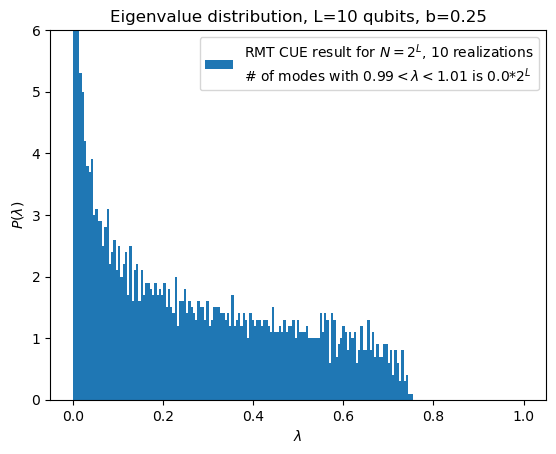

In [4]:
modes_one = round(len([i for i in eigenvals_0D if 0.99<i<1.01])/10/2**L,2)
plt.hist(eigenvals_0D,
         bins=np.linspace(0,1,200),
         weights=np.ones_like(eigenvals_0D)/10,
         label='RMT CUE result for $N=2^L$, 10 realizations\n# of modes with $0.99<\lambda<1.01$ is %s*$2^L$' % modes_one
        )
plt.ylim(0,6)
plt.title('Eigenvalue distribution, L=%s qubits, b=%s' % (L,b))
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$P(\lambda)$')
plt.show()

In [5]:
%%time

L=10
runs=10
b=1/2

Lambda_P = Rand_mx_simulation(
                n=2**L,
                b=b,
                sigma=np.sqrt(2.0)/np.sqrt(2**L),
                runs=runs,
                P0_flag=True,
                CUE_flag=False,
                initial_state='pure'
            )
Lambda_P.get_eignevals_W()

eigenvals_0D = Lambda_P.eigenvals

CPU times: user 46.8 s, sys: 1.69 s, total: 48.5 s
Wall time: 10.7 s


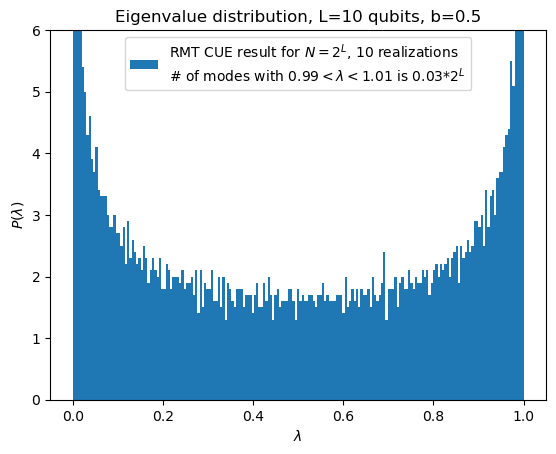

In [6]:
modes_one = round(len([i for i in eigenvals_0D if 0.99<i<1.01])/10/2**L,2)
plt.hist(eigenvals_0D, 
         bins=np.linspace(0,1,200), 
         weights=np.ones_like(eigenvals_0D)/10, 
         label='RMT CUE result for $N=2^L$, 10 realizations\n# of modes with $0.99<\lambda<1.01$ is %s*$2^L$' % modes_one 
        )
plt.ylim(0,6)
plt.title('Eigenvalue distribution, L=%s qubits, b=%s' % (L,b))
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$P(\lambda)$')
plt.show()

In [7]:
%%time

L=10
runs=10
b=3/4

Lambda_P = Rand_mx_simulation(
                n=2**L,
                b=b,
                sigma=np.sqrt(2.0)/np.sqrt(2**L),
                runs=runs,
                P0_flag=True,
                CUE_flag=False,
                initial_state='pure'
            )
Lambda_P.get_eignevals_W()

eigenvals_0D = Lambda_P.eigenvals

CPU times: user 51.2 s, sys: 2.07 s, total: 53.2 s
Wall time: 12.2 s


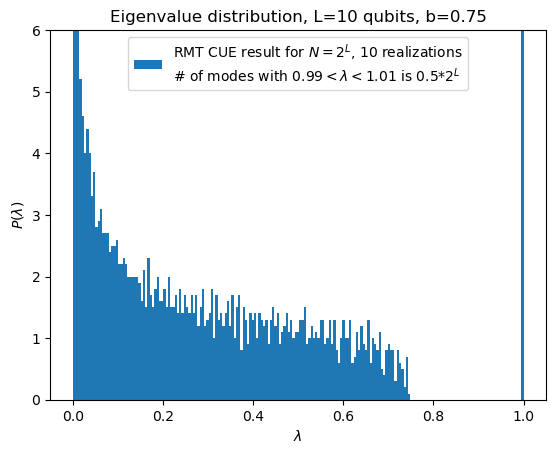

In [8]:
modes_one = round(len([i for i in eigenvals_0D if 0.99<i<1.01])/10/2**L,2)
plt.hist(eigenvals_0D, 
         bins=np.linspace(0,1,200), 
         weights=np.ones_like(eigenvals_0D)/10, 
         label='RMT CUE result for $N=2^L$, 10 realizations\n# of modes with $0.99<\lambda<1.01$ is %s*$2^L$' % modes_one 
        )
plt.ylim(0,6)
plt.title('Eigenvalue distribution, L=%s qubits, b=%s' % (L,b))
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$P(\lambda)$')
plt.show()